In [ ]:
!pip install kagglehub
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("fmena14/crowd-counting")

print("Path to dataset files:", path)


100%|██████████| 1.18G/1.18G [00:30<00:00, 41.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3"
files = os.listdir(dataset_path)

for file in files:
    print(file)


labels.npy
images.npy
frames
labels.csv


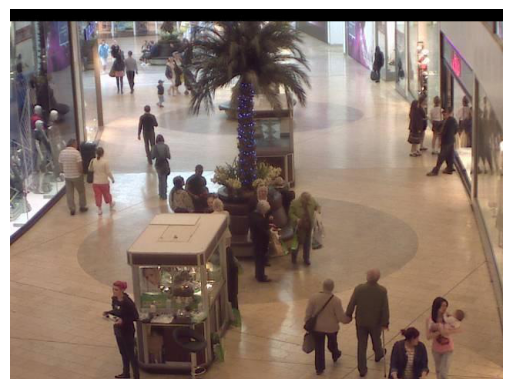

Label for first image: [35]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the images and labels from the .npy files
images_path = os.path.join(dataset_path, 'images.npy')
labels_path = os.path.join(dataset_path, 'labels.npy')

images = np.load(images_path)
labels = np.load(labels_path)

# Display the first image from the dataset
plt.imshow(images[0])  # Display the first image
plt.axis('off')  # Hide axis
plt.show()

# Print the label for the first image (it might represent a count or other data)
print("Label for first image:", labels[0])


In [ ]:
import os
import numpy as np

dataset_path = "/root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3"

images_path = os.path.join(dataset_path, 'images.npy')
labels_path = os.path.join(dataset_path, 'labels.npy')

images = np.load(images_path, mmap_mode=None)
labels = np.load(labels_path)

print("✅ Full dataset loaded")
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


✅ Full dataset loaded
Images shape: (2000, 480, 640, 3)
Labels shape: (2000, 1)


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import cv2
import random
from tqdm import tqdm

# Create a folder to save selected images
output_dir = "/content/crowd_subset"
os.makedirs(output_dir, exist_ok=True)

# Load full dataset
images = np.load(os.path.join(dataset_path, 'images.npy'), mmap_mode=None)
labels = np.load(os.path.join(dataset_path, 'labels.npy'))

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)

# Randomly select 500 indices
random_indices = random.sample(range(len(images)), 500)

# Helper to classify density
def classify_density(label_count):
    if label_count <= 10:
        return "Low"
    elif label_count <= 25:
        return "Medium"
    else:
        return "High"

# Collecting data
data = []

for idx, i in enumerate(tqdm(random_indices)):
    img = images[i].astype(np.uint8)
    label_count = int(labels[i][0])
    file_name = f"image_{idx+1:03d}.png"

    # Save the image
    cv2.imwrite(os.path.join(output_dir, file_name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    # Run YOLOv5 inference
    results = model(img)
    detections = results.pandas().xyxy[0]
    detected_people = sum(detections['name'] == 'person')

    # Save record
    data.append({
        "Image File Name": file_name,
        "Detected People": detected_people,
        "Density Class": classify_density(label_count)
    })

# Create Excel file
df = pd.DataFrame(data)
excel_path = "/content/crowd_density_report.xlsx"
df.to_excel(excel_path, index=False)

print(f"✅ Done. Images saved to: {output_dir}")
print(f"✅ Excel file saved to: {excel_path}")


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-4-22 Python-3.11.12 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 83.4MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
  0%|          | 0/500 [00:00<?, ?it/s]/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
  0%|          | 1/500 [00:00<04:31,  1.84it/s]/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
  0%|          | 2/500 [00:00<03:45,  2.20it/s]/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

✅ Done. Images saved to: /content/crowd_subset
✅ Excel file saved to: /content/crowd_density_report.xlsx


In [ ]:
import pandas as pd

# Load the Excel file
path = "/content/crowd_density_report.xlsx"
df = pd.read_excel(path)

# Function to classify density
def classify_density(count):
    if count <= 10:
        return "Low"
    elif 11 <= count <= 25:
        return "Medium"
    else:
        return "High"

# Remove the old 'Density Classification' column if it exists
if 'Density Classification' in df.columns:
    df.drop(columns=['Density Classification'], inplace=True)

# Add corrected density classification based on 'Detected People'
df['Density Classification'] = df['Detected People'].apply(classify_density)

# Save the corrected file
updated_path = "/content/updated_crowd_density_report_done.xlsx"
df.to_excel(updated_path, index=False)

print(f"Cleaned and corrected file saved at: {updated_path}")


Cleaned and corrected file saved at: /content/updated_crowd_density_report_done.xlsx


In [ ]:
import shutil

# Save Excel file
excel_path = "/content/crowd_density_report.xlsx"
df.to_excel(excel_path, index=False)

# Zip the folder
shutil.make_archive("/content/crowd_subset", 'zip', output_dir)

print("✅ Images saved in folder and zipped.")
print("✅ Excel saved at:", excel_path)


✅ Images saved in folder and zipped.
✅ Excel saved at: /content/crowd_density_report.xlsx


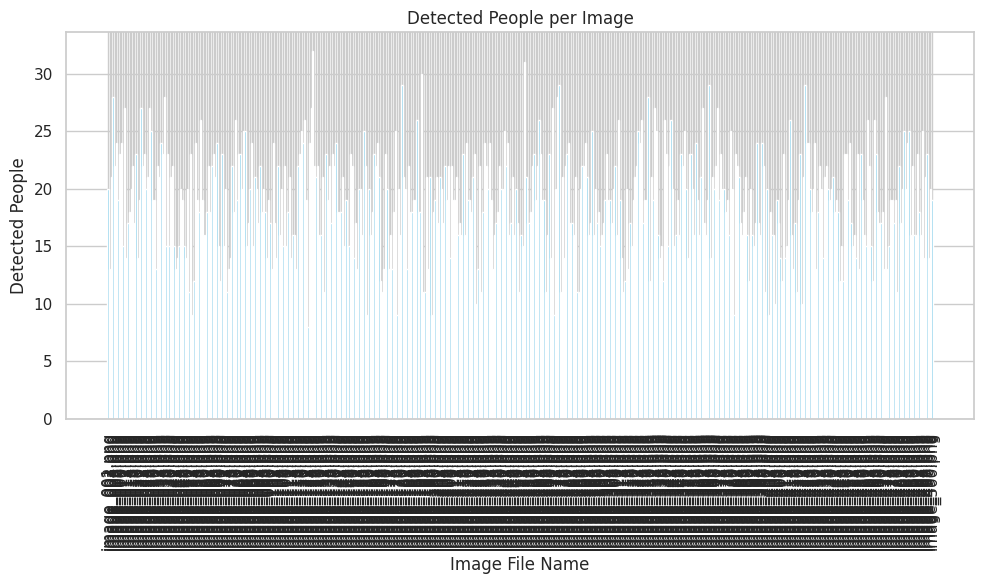

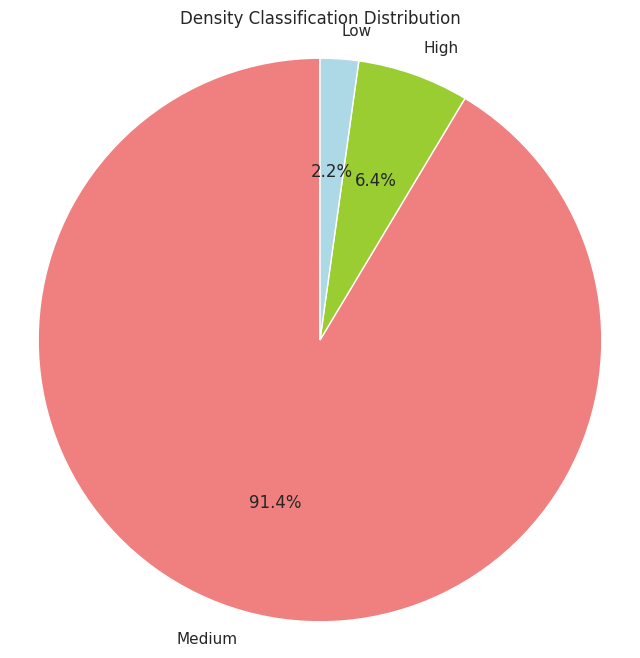

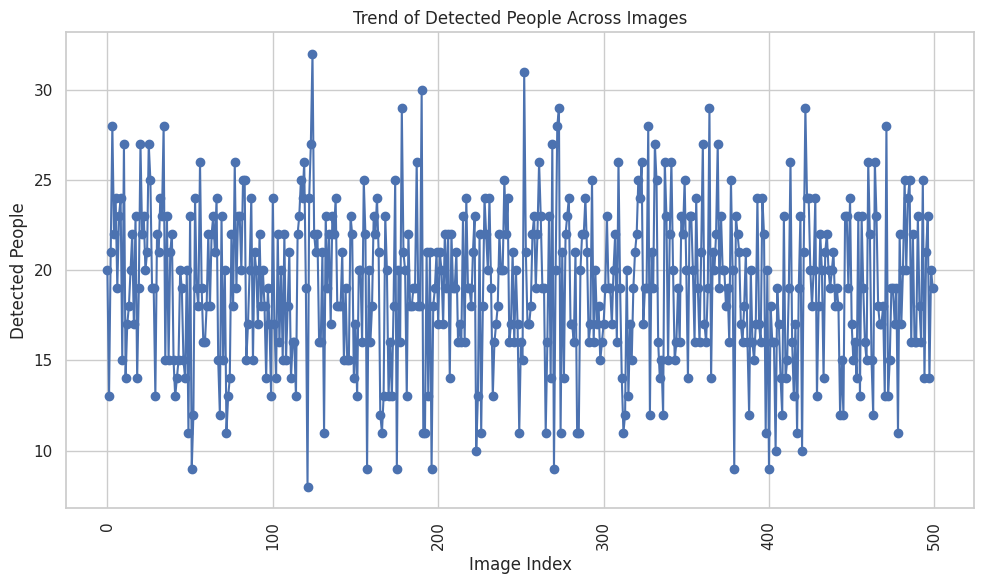

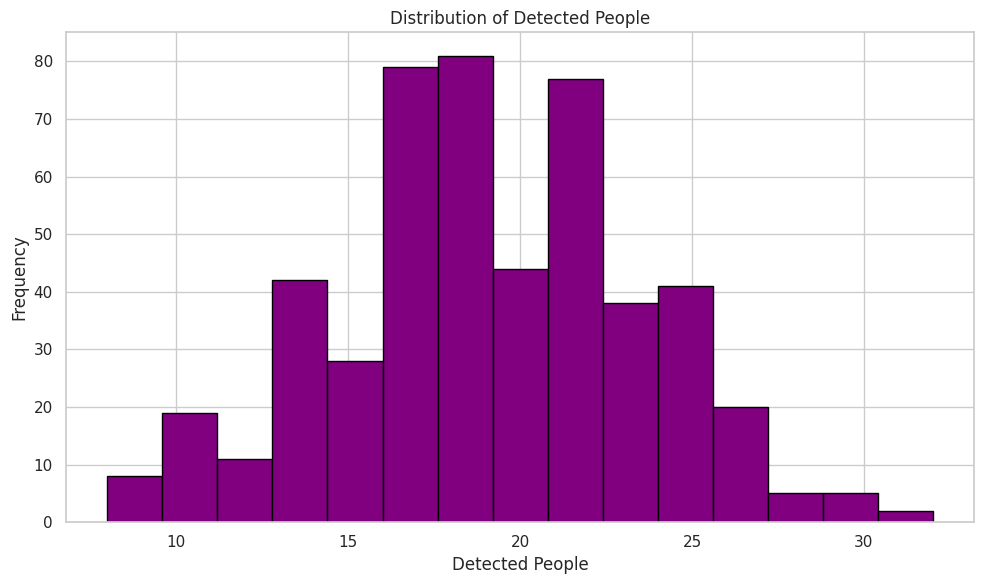

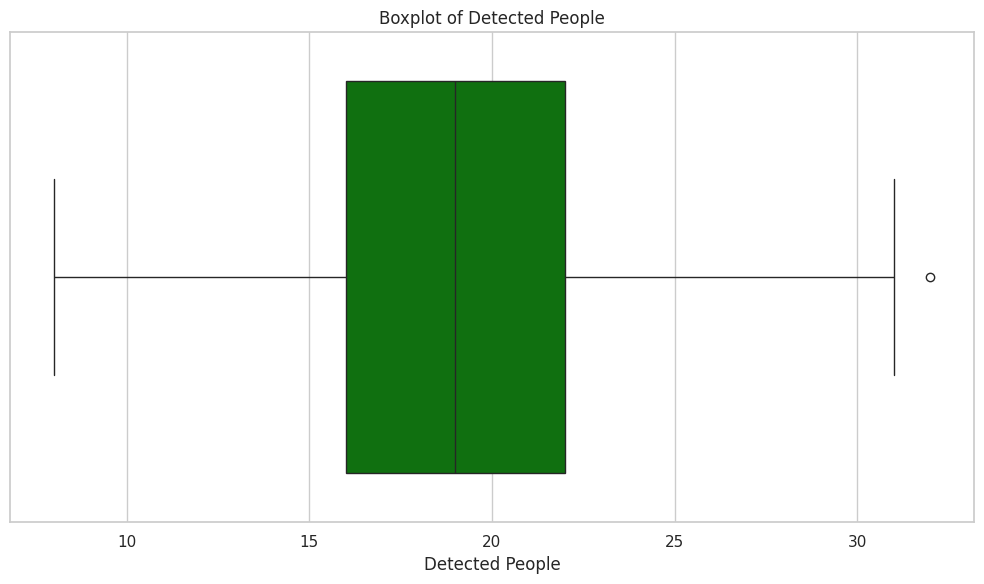

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned Excel file
df = pd.read_excel("/content/updated_crowd_density_report_done.xlsx")

# Set up the plotting style
sns.set(style="whitegrid")

# Plot 1: Bar Graph for Detected People
plt.figure(figsize=(10, 6))
plt.bar(df['Image File Name'], df['Detected People'], color='skyblue')
plt.xlabel('Image File Name')
plt.ylabel('Detected People')
plt.title('Detected People per Image')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Plot 2: Pie Chart for Density Classification Distribution
density_counts = df['Density Classification'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(density_counts, labels=density_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'yellowgreen', 'lightblue'])
plt.title('Density Classification Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Plot 3: Line Chart for Detected People Trend
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Detected People'], marker='o', linestyle='-', color='b')
plt.xlabel('Image Index')
plt.ylabel('Detected People')
plt.title('Trend of Detected People Across Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot 4: Histogram for Distribution of Detected People
plt.figure(figsize=(10, 6))
plt.hist(df['Detected People'], bins=15, color='purple', edgecolor='black')
plt.xlabel('Detected People')
plt.ylabel('Frequency')
plt.title('Distribution of Detected People')
plt.tight_layout()
plt.show()

# Plot 5: Boxplot for Detected People
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Detected People'], color='green')
plt.xlabel('Detected People')
plt.title('Boxplot of Detected People')
plt.tight_layout()
plt.show()
